In [1]:

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

%matplotlib inline

from torch import autograd
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.optim as optim
import torchvision.datasets as datasets
import time
import os
# useful v1 functions
# import import_ipynb 
# import importlib
# import metamaterials_GAN_v1
# importlib.reload(metamaterials_GAN_v1)

# from metamaterials_GAN_v1 import plot_shape, load_item, quarter, dataset, dataloader

if __name__ == "__main__":
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU detected")

Torch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090


In [2]:
def plot_shape(shape_matrix):
    """Plot the generated shape (expects input shape (1, 32, 32) or (32, 32))."""
    # Squeeze channel if present
    if shape_matrix.ndim == 3 and shape_matrix.shape[0] == 1:
        shape_matrix = shape_matrix.squeeze(0)  # → (32, 32)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.set_facecolor('#301934')
    ax.imshow(shape_matrix, origin='upper', cmap='viridis')  # add colormap if needed
    plt.axis('off')
    # print(f'size: {shape_matrix.shape[0]} x {shape_matrix.shape[1]}')
    plt.show()


def load_item(item, p= True, action=''):
    if action=='':
        if p:
            print(f'Cond: {item[0]}')
            print(f'Params: {item[1]}')
        plot_shape(item[2])
        return {'Cond':item[0], 'Params':item[1]}
    if action == 'shape':
        return item[3]
    
def quarter(matrix):
    return matrix[:32, :32]

In [3]:
# import h5py
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# %matplotlib inline

# # class WaveguideDataset(Dataset):
# #     def __init__(self, h5_file):
# #         self.h5_file = h5py.File(h5_file, 'r')
# #         weights = self.h5_file['weight_train'][:]  # Shape: (N, 4)
# #         weight_sums = np.sum(weights, axis=1)  # Shape: (N,)
# #         patterns = self.h5_file['pattern_train'][:] # Shape: (N, 64, 64)
# #         mask = weight_sums < 100 # Mask that sorts for just good data 

# #         self.eigenmodes = torch.tensor(self.h5_file['neff_train'][:][mask], dtype=torch.float32)   # (N, 4)
# #         self.weights = torch.tensor(weights[mask], dtype=torch.float32)  
# #                                  # (N, 4)
# #         self.paramss = torch.tensor(self.h5_file['params_train'][:][mask], dtype=torch.float32)    # (N, 4)
# #         waveguides_01 = torch.tensor(np.array([quarter(p) for p in patterns])[mask], dtype=torch.float32).unsqueeze(1)  # (N, 32, 32)

# #         # Possibly try normalizing all parameters, if training doesn't work
# #         # self.eigenmodes = (self.eigenmodes - self.eigenmodes.mean(0)) / self.eigenmodes.std(0)
# #         # self.weights = (self.weights - self.weights.mean(0)) / self.weights.std(0)
# #         # self.paramss = (self.paramss - self.paramss.mean(0)) / self.paramss.std(0)

# #         self.waveguides = (waveguides_01-0.5) * 2

# #     def __len__(self):
# #         return len(self.waveguides)

# #     def __getitem__(self, idx):
# #         eigenmode = self.eigenmodes[idx]  # (10, H, W)
# #         weight = self.weights[idx]  # (10,)
# #         params = self.paramss[idx]
# #         waveguide = self.waveguides[idx]  # (1, H, W)
# #         cond = torch.cat((eigenmode, weight), dim=0) # size (8,)

# class WaveguideDataset(Dataset):
#     def __init__(self, h5_path):
#         self.h5_path = h5_path
#         self.indices = self._get_valid_indices()

#     def _get_valid_indices(self):
#         with h5py.File(self.h5_path, 'r') as f:
#             weights = f['weight_train'][:]
#             weight_sums = np.sum(weights, axis=1)
#             return np.where(weight_sums < 100)[0]

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         with h5py.File(self.h5_path, 'r') as f:
#             i = self.indices[idx]
#             eigenmode = torch.tensor(f['neff_train'][i], dtype=torch.float32)
#             weight = torch.tensor(f['weight_train'][i], dtype=torch.float32)
#             param = torch.tensor(f['params_train'][i], dtype=torch.float32)
#             pattern = torch.tensor(quarter(f['pattern_train'][i]), dtype=torch.float32).unsqueeze(0)
#             condition = torch.cat((eigenmode, weight), dim=0)
#         return condition, param, pattern


# dataset = WaveguideDataset('train_test_split.h5')
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
# # print(dataloader)
# if __name__ == "__main__":
#     load_item(dataset.__getitem__(2))
#     # print(dataset.waveguides.shape)



In [3]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block, for image processing
        '''
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


In [4]:
class UnetDown(nn.Module):
    """
    Downsampling path for U-Net, reduces spatial resolution while increasing feature depth
    Input: Image batch, size (batchsize, 1, 32, 32)
    Output: size (batchsize, out_channels, 16, 16)
    Output:
    """
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(
            in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Doubles spatial dimensions, halves feature dimensions
        # My channel dimension for image will always be 1, greyscale
        return self.model(x)


In [5]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        Doubles spatial size, but decreases channels:
        input: 2 vectors of size (binsize, in_channels / 2, h, w) 
        output: (binsize, outchannels, 2h, 2w)
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        """
        x is the upsampled features from previous decoder layer
        skip is the skip connection from the encoder, same size as x
        """
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x
a = torch.empty(32, 2, 16,16)
b = UnetUp(4,1)
print(b.forward(a,a).size())

torch.Size([32, 1, 32, 32])


In [6]:
class EmbedFC(nn.Module):
    """
    Use FC layer for embedding 1-d metadata, like modes+weights
    (putting into higher dimension)
    Effectively our conditional
    input: Conditional, size (batchsize, input_dim = 4+4)
    Output: Higherdimensional tensor, size (batchsize, output_dim)
    
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

a = torch.empty(32, 8)
b = EmbedFC(8, 32)
print(b.forward(a).size())

torch.Size([32, 32])


In [7]:
class ContextUnet(nn.Module):
    """
    U-Net style neural network for conditional image generation, conditioning on
    both timestep t and a context vector c (modes+weights)

    ** Diverges from MNIST Example:
        - instead of inputting n_classes, input the length of my
          conditional, as is continuous 8
    """
    def __init__(self, in_channels, n_feat = 256, cond_dim=8):
        """
        in_channels (1 for greyscale), n_feat is base feature size, n_classes is number of labels
        """
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.cond_dim = cond_dim

        # Lifts image channels to n_feat using our residual block
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat) # (batchsize, 1, 32, 32) -> (batchsize, 2, 16, 16)
        self.down2 = UnetDown(n_feat, 2 * n_feat) # (batchsize, 2, 16, 16) -> (batchsize, 4, 8, 8)

        # reduces 2d feature map down2 into small latent vector of shape
        # (batchsize, 2*n_feat, 1, 1) via 7x7 average pooling
        self.to_vec = nn.Sequential(nn.AvgPool2d(8), nn.GELU())

        # Embeds timestep t and context c into vectors that will later be reshaped and added
        # to upsampling path
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(cond_dim, 2*n_feat)
        self.contextembed2 = EmbedFC(cond_dim, 1*n_feat)

        # upsamples latent vector (hiddenvec) back to 2d spatial mapping
        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 8, 8), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )
        # upsampling (decoder) blocks that fuse upsampled features with skip connections from
        # the encoder
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # final processing layer to reduce features back to the original number of channels
        # Ideally produces the final denoised image!
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is (noisy) image, size (batchsize, in_channels, 32, 32)
        # c is context label,size (batchsize, 8)
        # t is timestep scalar, size (batchsize, 1)
        # Binary mask for whether to apply conditioning 
        # probably will not need because need conditioning

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2) # pooled latent representation

        # convert context to one hot embedding
        
        # embed context, time step, reshapes them for broadcasting in upsampling layers
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

model = ContextUnet(1, 64, 8)
x = torch.zeros(32, 1, 32, 32)           # batch of noisy grayscale images
c = torch.zeros(32, 8)          # context labels
t = torch.rand(32, 1)                    # timestep in [0, 1]

output = model.forward(x, c, t)
print(output.shape)



torch.Size([32, 1, 32, 32])


In [8]:
def ddpm_schedules(beta1, beta2, T):
    """
    Precomputes all noise scheduling terms needed for training and sampling
    from a denoising diffusion probabilistic model
    Uses a sequence of gradually increasing noise level over T timesteps
    beta1: starting noise level, O(1e-4)
    beta2: final noise level, O(0.02)
    T: number of time steps
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1 # noise variance schedule (for every time t in T)
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    # dictionary of schedule terms
    return {
        "alpha_t": alpha_t,  # \alpha_t , signal retention at time step t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t} , noise scaling factor
        "alphabar_t": alphabar_t,  # \bar{\alpha_t} , cumulative signal retention
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}} , scales clean image during noise
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}} , noise strength
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}} , for reverse diffusion
    }


In [12]:

class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model
    """
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        """
        betas: tuple (beta1, beta2) for linear noise schedule
        n_T: total number of diffusion steps (e.g. 1000)
        drop_prob: probability of dropping conditioning (for classifier free guidance)
        """
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        x: clean image tensor, size (batchsize, 1, 32, 32)
        c: conditional vector, size (batchsize, 32)
        this method is used in training, so samples t and noise randomly
        """

        # t ~ Uniform(0, n_T)
        # sample a random timestep t for each item in the batch, 
        # determines how much noise to add
        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        # Generates noising image x_t from clean image x
        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        # context_mask = torch.bernoulli(
        #     torch.zeros_like(c)+self.drop_prob).to(self.device)

        # return MSE between added noise, and our predicted noise
        # runs x_t, c, t, and context_mask through model, compares predicted noise
        # with actual noise using MSE
        # return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T))

    def sample(self, n_sample, size, device, c_i, guide_w=0.0):
        """
        n_sample: number of images to generate
        size: shape of each image, [1,32,32]
        guid_w: guidance strength, 0=no guidance, >0=stronger conditioning (what we want)
        """
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        # x_T ~ N(0, 1), sample initial noise
        x_i = torch.randn(n_sample, *size).to(device)  # start from pure noise
        # context for us just cycles throught the mnist labels

        x_i_store = []  # keep track of generated steps in case want to plot something
        print()
        # Iterate over timesteps in revers (from noise -> image)
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}', end='\r')
            t_is = torch.tensor([i / self.n_T], device=device).repeat(n_sample, 1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0 # add noise at all steps except final one

            # predict the noise using both conditioned and unconditioned branches
            eps = self.nn_model(x_i, c_i, t_is)
            # apply classifier-free guidance formula: ϵ = (1 + w)⋅ϵ_cond − w⋅ϵ_uncond

            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            # save frames for visualization every 20 steps and near the end
            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        # returns final denoised image x_i and intermediate steps x_i_store
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

ddpm = DDPM(model, betas=(1e-4, 0.02), n_T=10, device='cpu')
x = torch.zeros(4, 1, 32, 32)
c = torch.zeros(4, 8)
loss = ddpm.forward(x, c)
print(loss)

samples, history = ddpm.sample(n_sample=4, size=(1, 32, 32), device='cpu', c_i=c, guide_w=2.0)
print(samples)

tensor(1.2463, grad_fn=<MseLossBackward0>)

tensor([[[[-0.3801,  1.2070, -0.0964,  ...,  0.9082,  0.0357, -1.9822],
          [-0.2121, -0.4766,  2.3842,  ..., -0.4270, -2.6592,  1.0640],
          [ 0.7450,  0.8310,  0.0835,  ..., -1.4965,  0.1328, -1.6090],
          ...,
          [-0.9075,  1.2703,  1.7457,  ...,  0.8131, -0.3251, -0.1829],
          [ 0.0361,  0.8516,  1.3147,  ..., -0.6047, -0.6771, -3.1600],
          [-1.0778,  2.9013,  1.7012,  ...,  0.6445,  1.0200, -0.5728]]],


        [[[-0.4061, -1.1503, -0.8728,  ..., -0.5742,  0.3262,  0.2232],
          [-0.2635, -0.4534,  1.1892,  ..., -0.7738,  0.6403,  0.3021],
          [-0.0970, -1.0676, -0.6543,  ...,  0.0576,  0.5103, -2.3271],
          ...,
          [-0.3194,  0.7655,  1.3672,  ..., -0.3008,  0.3372,  0.2739],
          [ 0.4469,  0.5719,  0.3407,  ...,  0.5888, -0.1949, -1.6554],
          [ 0.0323, -0.0689,  2.0137,  ..., -1.9778,  0.5531, -0.8203]]],


        [[[ 2.0071, -0.1498,  0.2692,  ...,  0.5043, -

In [ ]:
# n_epoch = 20
# batch_size = 32
# n_T = 400
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# n_feat = 128
# lrate = 1e-4
# save_model = True
save_dir = './data/waveguide_diffusion_outputs/'
# guide_weights = [0.0, 0.5, 2.0]  # guidance scaling

os.makedirs(save_dir, exist_ok=True)

# # Define the model
# model = ContextUnet(in_channels=1, n_feat=n_feat, cond_dim=8)  # cond_dim = 4 eig + 4 wts
# ddpm = DDPM(nn_model=model, betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
# loss = ddpm.sample(x,c)

In [9]:
# dataset = WaveguideDataset('train_test_split.h5')
from waveguide_dataset import WaveguideDataset
dataset = WaveguideDataset('train_test_split.h5')
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)
# #dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=5)
# pbar = tqdm(dataloader)
# i=0
# for c, p, x in pbar:
#    i+=1
# print(i)



In [ ]:
def train_waveguide(dataset):

    # hardcoding these here
    n_epoch = 20
    batch_size = 256
    n_T = 400 # difusion steps
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # WILL HAVE TO CHANGE THIS to cond_dim = 8
    cond_dim = 8

    n_feat = 128 # Feature size for U-Net, may have to make 256
    lrate = 1e-4
    save_model = True
    save_dir = './data/diffusion_v1_outputs_normalized/'
    os.makedirs(save_dir, exist_ok=True)

    ws_test = [0.0, 0.5, 1.0, 2.0] # strength of generative guidance

    # FOR DISPLAY CHECK
    ########################################
    n_sample = 40  # 5x8, or whatever number you want
    condition_list = []
    x_real = []
    # Pull first n_sample items from dataset, 
    for i in range(n_sample):
        cond_i, _, x_i = dataset[i]  # cond: (8,), x_i: (1, 32, 32)
        condition_list.append(cond_i)
        x_real.append(x_i)
    c_i = torch.stack(condition_list).to(device)  # (n_sample, 8)
    x_real = torch.stack(x_real).to(device) 
    ########################################

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, cond_dim=cond_dim), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)

    ddpm.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)

    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate) # ADAM optimizer for training, keep

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay, so training quicker at begining, more fine-tuned at end?
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        # batch training
        pbar = tqdm(dataloader)
        loss_ema = None # For display

        for c, p, x in pbar: # loops over batches from dataset
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c) # predicts noise from noisy image
            loss.backward() # Computes EMA-smoothed loss for live progress display, backprops to update weights

            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item() 
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval() # evaluates model without gradient
        with torch.no_grad():
            for w_i, w in enumerate(ws_test):
                # WILL HAVE TO CHANGE TO MAKE WORK WITH MY SAMPLING STRATEGY, ie grabbing first 40 waveguides and generating new ones
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 32, 32), device, c_i=c_i, guide_w=w) # samples n_sample generated images, 

                # append some real images at bottom, order by class also
                # x_real = torch.Tensor(x_gen.shape).to(device)
                # for k in range(n_classes):
                #     for j in range(int(n_sample/n_classes)):
                #         try: 
                #             idx = torch.squeeze((c == k).nonzero())[j]
                #         except:
                #             idx = 0
                #         x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real], dim=0)
                grid = make_grid(x_all*-1 + 1, nrow=8)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=n_sample // 8, ncols=8,sharex=True,sharey=True,figsize=(8,3))

                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample // 8)):
                            for col in range(8):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                img = -x_gen_store[i, (row*8) + col, 0]
                                plots.append(axs[row,col].imshow(img, cmap='gray', vmin=img.min(), vmax=img.max()))
                                # plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots

                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        # optionally save model

        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")


Tasks to complete: completely rework training function for my project
Maybe start with just generating the waveguides, then move to generating waveguides and parameters

epoch 0


loss: 0.0082: 100%|██████████| 4293/4293 [07:36<00:00,  9.40it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep0_w0.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep0_w0.0.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep0_w0.5.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep0_w0.5.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep0_w2.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep0_w2.0.gif
epoch 1


loss: 0.0065: 100%|██████████| 4293/4293 [07:27<00:00,  9.59it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep1_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep1_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep1_w2.0.png
epoch 2


loss: 0.0061: 100%|██████████| 4293/4293 [07:13<00:00,  9.91it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep2_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep2_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep2_w2.0.png
epoch 3


loss: 0.0058: 100%|██████████| 4293/4293 [07:12<00:00,  9.92it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep3_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep3_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep3_w2.0.png
epoch 4


loss: 0.0054: 100%|██████████| 4293/4293 [07:25<00:00,  9.63it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep4_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep4_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep4_w2.0.png
epoch 5


loss: 0.0063: 100%|██████████| 4293/4293 [07:13<00:00,  9.91it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep5_w0.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep5_w0.0.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep5_w0.5.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep5_w0.5.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep5_w2.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep5_w2.0.gif
epoch 6


loss: 0.0051: 100%|██████████| 4293/4293 [07:14<00:00,  9.89it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep6_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep6_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep6_w2.0.png
epoch 7


loss: 0.0050: 100%|██████████| 4293/4293 [07:14<00:00,  9.89it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep7_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep7_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep7_w2.0.png
epoch 8


loss: 0.0050: 100%|██████████| 4293/4293 [07:13<00:00,  9.90it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep8_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep8_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep8_w2.0.png
epoch 9


loss: 0.0049: 100%|██████████| 4293/4293 [07:13<00:00,  9.91it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep9_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep9_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep9_w2.0.png
epoch 10


loss: 0.0049: 100%|██████████| 4293/4293 [07:13<00:00,  9.90it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep10_w0.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep10_w0.0.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep10_w0.5.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep10_w0.5.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep10_w2.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep10_w2.0.gif
epoch 11


loss: 0.0049: 100%|██████████| 4293/4293 [07:14<00:00,  9.88it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep11_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep11_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep11_w2.0.png
epoch 12


loss: 0.0046: 100%|██████████| 4293/4293 [07:14<00:00,  9.88it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep12_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep12_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep12_w2.0.png
epoch 13


loss: 0.0046: 100%|██████████| 4293/4293 [07:19<00:00,  9.77it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep13_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep13_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep13_w2.0.png
epoch 14


loss: 0.0047: 100%|██████████| 4293/4293 [07:14<00:00,  9.89it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep14_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep14_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep14_w2.0.png
epoch 15


loss: 0.0047: 100%|██████████| 4293/4293 [07:13<00:00,  9.91it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep15_w0.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep15_w0.0.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep15_w0.5.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep15_w0.5.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep15_w2.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep15_w2.0.gif
epoch 16


loss: 0.0045: 100%|██████████| 4293/4293 [07:13<00:00,  9.90it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep16_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep16_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep16_w2.0.png
epoch 17


loss: 0.0045: 100%|██████████| 4293/4293 [07:13<00:00,  9.91it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep17_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep17_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep17_w2.0.png
epoch 18


loss: 0.0044: 100%|██████████| 4293/4293 [07:13<00:00,  9.90it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep18_w0.0.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep18_w0.5.png

saved image at ./data/diffusion_v1_outputs_normalized/image_ep18_w2.0.png
epoch 19


loss: 0.0044: 100%|██████████| 4293/4293 [07:13<00:00,  9.89it/s]



saved image at ./data/diffusion_v1_outputs_normalized/image_ep19_w0.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep19_w0.0.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep19_w0.5.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep19_w0.5.gif

saved image at ./data/diffusion_v1_outputs_normalized/image_ep19_w2.0.png
saved image at ./data/diffusion_v1_outputs_normalized/gif_ep19_w2.0.gif
saved model at ./data/diffusion_v1_outputs_normalized/model_19.pth


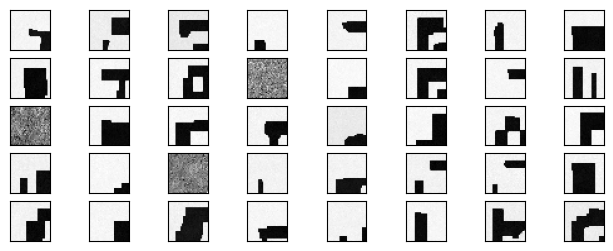

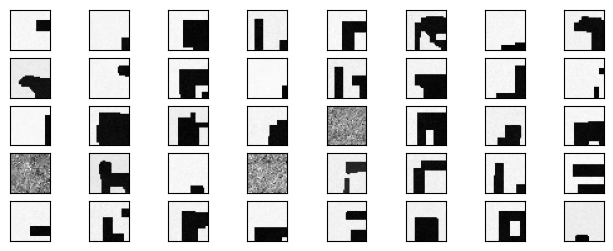

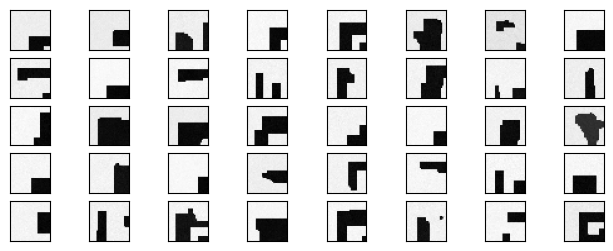

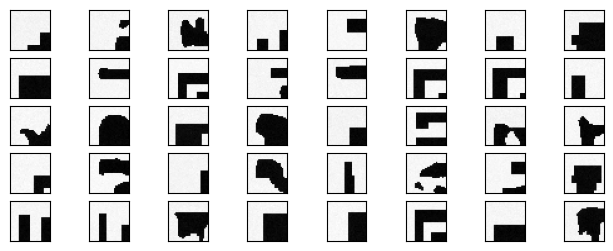

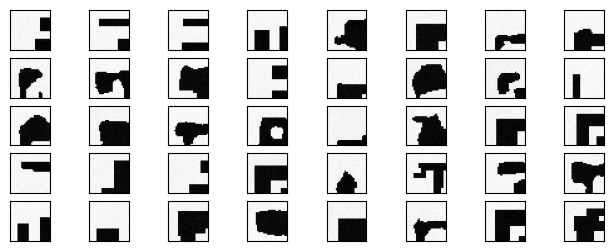

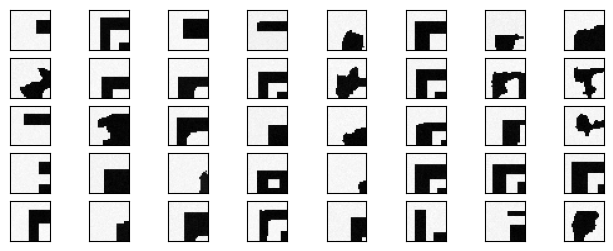

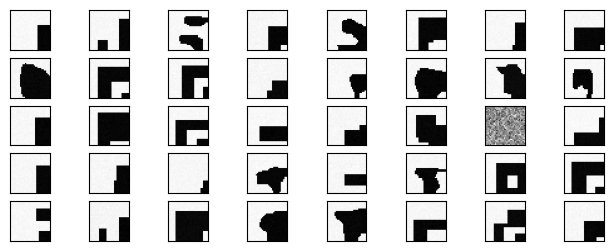

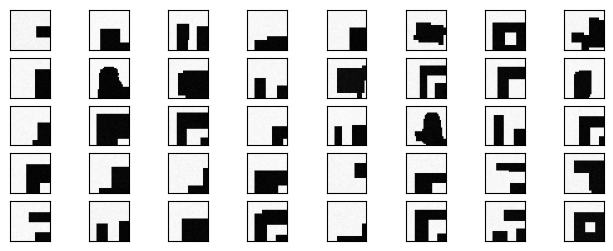

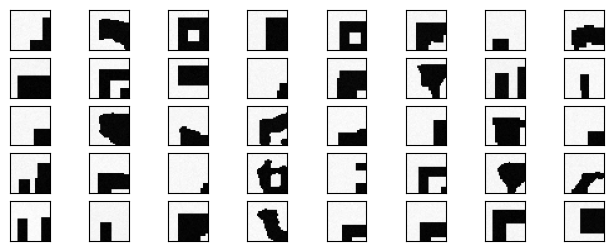

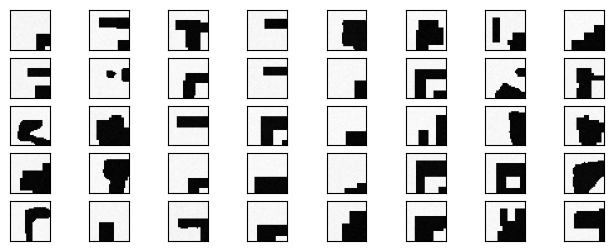

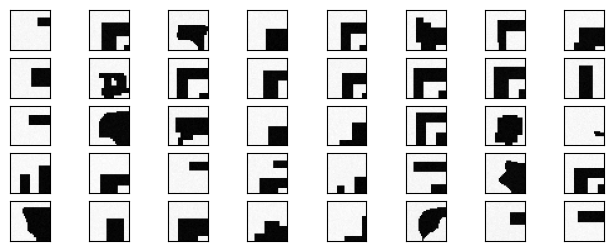

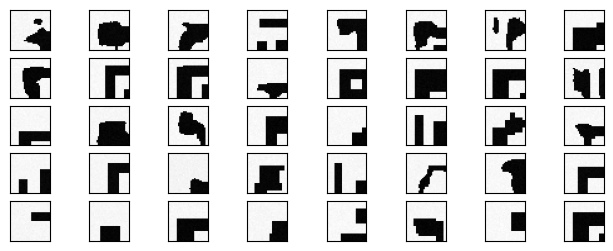

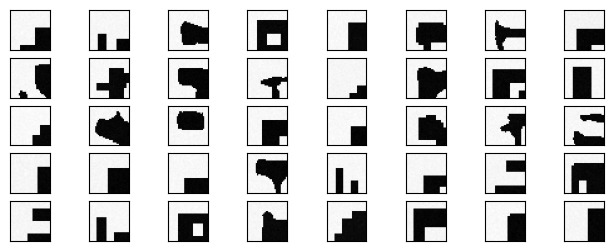

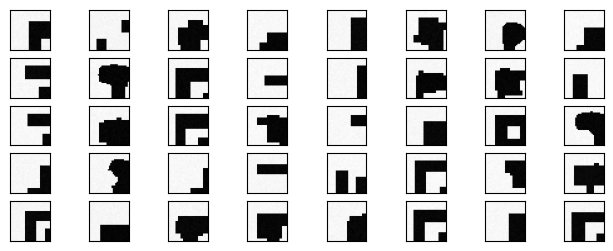

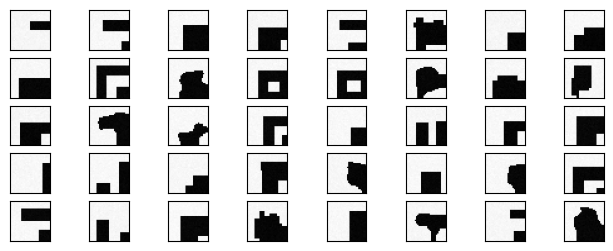

In [13]:

if __name__ == "__main__":
    train_waveguide(dataset)
